# **Federated Learning with (PeerReview)Flower and FedAvg**

### Installing dependencies

First of all, we install the necessary packages:

In [ ]:
# Multiple ways to import prflwr whether it is installed
# as a Python module, in a Colab environment or if source
# code is in a parent directory for local development.
def import_prflwr():
    import os
    try: import prflwr; return
    except: pass
    if "setup.py" in os.listdir("../.."):
        os.chdir("../..")
        try: import prflwr
        except: pass
        finally: os.chdir("experiments/fedls")
        if prflwr: return
    try:
        import google.colab
        os.system(
            "pip install git+https://github.com/passerim/peer-review-flower.git"
        )
        import prflwr; return
    except: raise ModuleNotFoundError("No module named 'prflwr'")


import_prflwr()

Now that we have all dependencies installed, we can import everything we need for this tutorial:

In [ ]:
import os
import random
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple

import flwr as fl
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from prflwr.simulation import start_simulation
from prflwr.utils import non_iid_partitions
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import transforms

## Setup

Set useful constants, experiments settings and random seed.

In [ ]:
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [ ]:
# Setting random seed for reproducibility
SEED = 123
set_seed(SEED)

# Experimental settings
DATASET = "CIFAR10"  # admissible values: "CIFAR10" or "CIFAR100"
NUM_ROUNDS = 30
NUM_CLIENTS = 100
LOCAL_EPOCHS = 5
BATCH_SIZE = 25
FRACTION_FIT = 0.1
FRACTION_EVAL = 0  # Model performance will be evaluated in a centralized way
print(f"Training for {NUM_ROUNDS} rounds")

# Device to use for training and evaluation
DEVICE = torch.device("cpu")
print(f"Training on {DEVICE}")

Training for 30 rounds
Training on cpu


## Data loading

Let's now load the CIFAR-10 (or CIFAR-100) training and test set, partition them into `NUM_CLIENTS` smaller datasets (each split into training and validation set) and wrap everything in their own `DataLoader`. Test data will be used to evaluate the performance of the model in a centralized way.

In [ ]:
def load_datasets(
    num_clients: int,
    dataset: str = "CIFAR10",
    src: str = "./data",
    iid: bool = True,
    concentration: float = 1,
    use_augmentation: bool = True,
) -> Tuple[List[DataLoader], List[DataLoader], DataLoader]:
    if dataset not in ["CIFAR10", "CIFAR100"]:
        raise ValueError(
            "Unknown dataset! Admissible values are: 'CIFAR10' or 'CIFAR100'."
        )

    # Download and transform CIFAR dataset (train and test)
    augmentation = (
        [
            transforms.RandomCrop(24),
            transforms.RandomHorizontalFlip(),
        ]
        if use_augmentation
        else []
    )
    transform = [
        transforms.CenterCrop(24),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
    trainset = getattr(torchvision.datasets, dataset)(
        src,
        train=True,
        download=True,
        transform=transforms.Compose([*augmentation, *transform]),
    )
    testset = getattr(torchvision.datasets, dataset)(
        src,
        train=False,
        download=True,
        transform=transforms.Compose([*transform]),
    )

    # Split training set into `num_clients` partitions to simulate different local datasets
    if not iid:
        targets = np.array(trainset.targets)
        idxs = np.array(range(len(targets)))
        dataset = [idxs, targets]
        train_partitions = non_iid_partitions(
            dataset,
            num_partitions=num_clients,
            concentration=concentration,
        )
        subsets = list(map(lambda p: Subset(trainset, p), train_partitions))
    else:
        partition_size = len(trainset) // num_clients
        lengths = [partition_size] * num_clients
        subsets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in subsets:
        len_val = len(ds) // 10  #  use 10% of client's data as validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets(NUM_CLIENTS)

100%|██████████| 170498071/170498071 [00:01<00:00, 100211577.65it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Model training/evaluation

Let's continue with the usual model definition (including `set_parameters` and `get_parameters`), training and test functions:

In [ ]:
class Net(nn.Module):
    def __init__(self, num_classes: int) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 5, 1, 1)
        self.fc1 = nn.Linear(16 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def train(net, trainloader, optimizer, epochs=1, verbose=True):
    """Train the network on the training set."""
    net.train()
    device = next(net.parameters()).device
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch, (images, labels) in enumerate(trainloader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= batch + 1
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, train accuracy {epoch_acc}")
    return epoch_loss, epoch_acc


def test(net, testloader):
    """Evaluate the network on the test set."""
    net.eval()
    device = next(net.parameters()).device
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    with torch.no_grad():
        for batch, (images, labels) in enumerate(testloader):
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= batch + 1
    accuracy = correct / total
    return loss, accuracy

Let's check model's correctness, then print some info about the datasets and splits.

In [ ]:
# Create an instance of the model
NUM_CLASSES = len(np.unique(testloader.dataset.targets))
net = Net(NUM_CLASSES).to(DEVICE)
with torch.no_grad():
    assert net(torch.randn((3, 24, 24), device=DEVICE)).shape == torch.Size(
        [1, NUM_CLASSES]
    )

# Print some stats about the model and the data
print("Model parameters:", sum(p.numel() for p in net.parameters() if p.requires_grad))
print("Client's trainset size:", len(trainloaders[0].dataset))
print("Client's validation set size:", len(valloaders[0].dataset))
print("Server's testset size:", len(testloader.dataset))

Model parameters: 45626
Client's trainset size: 450
Client's validation set size: 50
Server's testset size: 10000


## Flower client

To implement the Flower client, we create a subclass of `flwr.client.NumPyClient` and implement the three methods `get_parameters`, `fit`, and `evaluate`. Here, we also pass the `cid` to the client and use it to log additional details.

### Sending/receiving arbitrary values to/from clients

In some situations, we want to dinamically configure client side training and evaluation from the server-side, for example by setting the learning rate or the local epochs. Flower provides a way to send configuration values from the server to the clients using a dictionary. Clients receive values from the server through the `config` parameter and can read values from this dictionary.

In [ ]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        # Read values from config
        server_round = config["server_round"]
        local_epochs = config["local_epochs"]
        # Use values provided by the config
        print(f"[Client {self.cid}, round {server_round}] fit, config: {config}")
        set_parameters(self.net, parameters)
        optimizer = torch.optim.Adam(self.net.parameters())
        train(self.net, self.trainloader, optimizer, local_epochs)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(cid) -> FlowerClient:
    net = Net(NUM_CLASSES).to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader)

We can send the config dictionary from the server to the clients providing a function to the strategy that gets called every round of federated learning.

In [ ]:
def fit_config(server_round: int):
    config = {
        "server_round": server_round,  # The current round of federated learning
        "local_epochs":  LOCAL_EPOCHS,
    }
    return config

## Customizing the FedAvg strategy

The strategy encapsulates the federated learning algorithm, in this notebook we will use the standard version of FedAvg. We will also customize the parameters initilization of the global model and the centralized model evaluation.

### Server-side parameter **initialization**

Flower, by default, initializes the global model by asking one random client for the initial parameters, however when more control on the initialization is needed passing `initial_parameters` to the `FedAvg` strategy prevents Flower from asking one of the clients for the initial parameters and allows the developer to set custom parameters for the initial model.

In [ ]:
initial_parameters = fl.common.ndarrays_to_parameters(get_parameters(Net(NUM_CLASSES)))

### Server-side parameter **evaluation**

With Flower, we can evaluate the aggregated model on the server-side or on the client-side. Centralized evaluation is conceptually simpler: if there is a server-side dataset that can be used for evaluation purposes, then we can evaluate the newly aggregated model after each round of training without having to send the model to clients.

In [ ]:
# The `evaluate` function will be called by Flower after every round
def evaluate(
    server_round: int, parameters: fl.common.NDArrays, config: Dict[str, fl.common.Scalar]
) -> Optional[Tuple[float, Dict[str, fl.common.Scalar]]]:
    net = Net(NUM_CLASSES).to(DEVICE)
    set_parameters(net, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net, testloader)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    return loss, {"accuracy": accuracy}

## Running federated learning

Let's run a federated learning experiment with a large number of clients. We have 100 partitions, each holding 450 training and 50 validation examples. We configure the clients to perform 5 local training epochs. The federated learning simulation is started by the function `start_simulation`, in this case we will use the concurrent simulation implemented in PeerReviewFlower. The `start_simulation` function accepts a number of arguments:
* `client_fn` is used to create `FlowerClient` instances,
* the number of clients to simulate is specified by `num_clients`,
* the number of rounds `num_rounds` is encapsulated in a `flwr.server.ServerConfig`,
* `strategy` is used to specify the custom strategy we configured above.

In [ ]:
strategy = fl.server.strategy.FedAvg(
    fraction_fit=FRACTION_FIT,
    fraction_evaluate=FRACTION_EVAL,
    min_fit_clients=int(NUM_CLIENTS * FRACTION_FIT),
    min_evaluate_clients=int(NUM_CLIENTS * FRACTION_EVAL),
    min_available_clients=NUM_CLIENTS,
    initial_parameters=initial_parameters,  # Pass the initial parameters
    on_fit_config_fn=fit_config,            # Pass the fit_config function
    evaluate_fn=evaluate,                   # Pass the evaluation function
)

history = start_simulation(
    strategy=strategy,
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
)

INFO flower 2023-05-25 22:09:42,903 | app.py:69 | Starting Flower simulation, config: ServerConfig(num_rounds=30, round_timeout=None)
INFO:flower:Starting Flower simulation, config: ServerConfig(num_rounds=30, round_timeout=None)
INFO flower 2023-05-25 22:09:43,307 | server.py:86 | Initializing global parameters
INFO:flower:Initializing global parameters
INFO flower 2023-05-25 22:09:43,314 | server.py:266 | Using initial parameters provided by strategy
INFO:flower:Using initial parameters provided by strategy
INFO flower 2023-05-25 22:09:43,323 | server.py:88 | Evaluating initial parameters
INFO:flower:Evaluating initial parameters
INFO flower 2023-05-25 22:09:51,612 | server.py:91 | initial parameters (loss, other metrics): 2.3038880437612534, {'accuracy': 0.1018}
INFO:flower:initial parameters (loss, other metrics): 2.3038880437612534, {'accuracy': 0.1018}
INFO flower 2023-05-25 22:09:51,619 | server.py:101 | FL starting
INFO:flower:FL starting
DEBUG flower 2023-05-25 22:09:51,625 | 

Server-side evaluation loss 2.3038880437612534 / accuracy 0.1018
[Client 6, round 1] fit, config: {'server_round': 1, 'local_epochs': 5}
[Client 34, round 1] fit, config: {'server_round': 1, 'local_epochs': 5}
[Client 11, round 1] fit, config: {'server_round': 1, 'local_epochs': 5}
[Client 98, round 1] fit, config: {'server_round': 1, 'local_epochs': 5}
[Client 13, round 1] fit, config: {'server_round': 1, 'local_epochs': 5}[Client 52, round 1] fit, config: {'server_round': 1, 'local_epochs': 5}

Epoch 1: train loss 2.302466458744473, train accuracy 0.10888888888888888
Epoch 1: train loss 2.296084417237176, train accuracy 0.11333333333333333
Epoch 1: train loss 2.3011211819118924, train accuracy 0.12666666666666668
Epoch 1: train loss 2.2982745700412326, train accuracy 0.1111111111111111
Epoch 1: train loss 2.3045119841893515, train accuracy 0.10888888888888888
Epoch 1: train loss 2.3040381934907703, train accuracy 0.09777777777777778
Epoch 2: train loss 2.266396893395318, train accura

DEBUG flower 2023-05-25 22:10:09,107 | server.py:229 | fit_round 1 received 10 results and 0 failures
DEBUG:flower:fit_round 1 received 10 results and 0 failures
WARNING flower 2023-05-25 22:10:09,151 | fedavg.py:242 | No fit_metrics_aggregation_fn provided


Epoch 5: train loss 2.067408707406786, train accuracy 0.23777777777777778
Epoch 5: train loss 2.0784449179967246, train accuracy 0.21555555555555556
Epoch 5: train loss 2.106139255894555, train accuracy 0.18888888888888888
Epoch 5: train loss 2.0405496954917908, train accuracy 0.2288888888888889


INFO flower 2023-05-25 22:10:14,891 | server.py:116 | fit progress: (1, 2.109095280468464, {'accuracy': 0.2227}, 23.265837449999992)
INFO:flower:fit progress: (1, 2.109095280468464, {'accuracy': 0.2227}, 23.265837449999992)
INFO flower 2023-05-25 22:10:14,898 | server.py:163 | evaluate_round 1: no clients selected, cancel
INFO:flower:evaluate_round 1: no clients selected, cancel
DEBUG flower 2023-05-25 22:10:14,907 | server.py:215 | fit_round 2: strategy sampled 10 clients (out of 100)
DEBUG:flower:fit_round 2: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 2.109095280468464 / accuracy 0.2227
[Client 42, round 2] fit, config: {'server_round': 2, 'local_epochs': 5}
[Client 43, round 2] fit, config: {'server_round': 2, 'local_epochs': 5}
[Client 6, round 2] fit, config: {'server_round': 2, 'local_epochs': 5}
[Client 20, round 2] fit, config: {'server_round': 2, 'local_epochs': 5}
[Client 17, round 2] fit, config: {'server_round': 2, 'local_epochs': 5}[Client 71, round 2] fit, config: {'server_round': 2, 'local_epochs': 5}

Epoch 1: train loss 2.1369950903786554, train accuracy 0.19555555555555557
Epoch 1: train loss 2.1240064567989774, train accuracy 0.21555555555555556
Epoch 1: train loss 2.070145567258199, train accuracy 0.2088888888888889
Epoch 1: train loss 2.159985065460205, train accuracy 0.19111111111111112
Epoch 1: train loss 2.129077739185757, train accuracy 0.20222222222222222
Epoch 1: train loss 2.1191437906689115, train accuracy 0.24888888888888888
Epoch 2: train loss 2.0947126613722906, train accurac

DEBUG flower 2023-05-25 22:10:33,240 | server.py:229 | fit_round 2 received 10 results and 0 failures
DEBUG:flower:fit_round 2 received 10 results and 0 failures


Epoch 5: train loss 1.9237275918324788, train accuracy 0.27111111111111114
Epoch 5: train loss 1.9292448494169447, train accuracy 0.2866666666666667
Epoch 5: train loss 2.03671262661616, train accuracy 0.24
Epoch 5: train loss 2.003323641088274, train accuracy 0.26666666666666666


INFO flower 2023-05-25 22:10:37,089 | server.py:116 | fit progress: (2, 1.972492690384388, {'accuracy': 0.2673}, 45.463350521999985)
INFO:flower:fit progress: (2, 1.972492690384388, {'accuracy': 0.2673}, 45.463350521999985)
INFO flower 2023-05-25 22:10:37,094 | server.py:163 | evaluate_round 2: no clients selected, cancel
INFO:flower:evaluate_round 2: no clients selected, cancel
DEBUG flower 2023-05-25 22:10:37,100 | server.py:215 | fit_round 3: strategy sampled 10 clients (out of 100)
DEBUG:flower:fit_round 3: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.972492690384388 / accuracy 0.2673
[Client 99, round 3] fit, config: {'server_round': 3, 'local_epochs': 5}
[Client 11, round 3] fit, config: {'server_round': 3, 'local_epochs': 5}
[Client 76, round 3] fit, config: {'server_round': 3, 'local_epochs': 5}
[Client 48, round 3] fit, config: {'server_round': 3, 'local_epochs': 5}
[Client 8, round 3] fit, config: {'server_round': 3, 'local_epochs': 5}
[Client 0, round 3] fit, config: {'server_round': 3, 'local_epochs': 5}
Epoch 1: train loss 2.055303520626492, train accuracy 0.2288888888888889Epoch 1: train loss 1.9568774700164795, train accuracy 0.2777777777777778Epoch 1: train loss 1.9696391820907593, train accuracy 0.24444444444444444


Epoch 1: train loss 2.0653407639927335, train accuracy 0.21555555555555556
Epoch 1: train loss 2.006499595112271, train accuracy 0.24888888888888888
Epoch 1: train loss 2.0454425745540195, train accuracy 0.2311111111111111
Epoch 2: train loss 1.9285466074943542, train accuracy 

DEBUG flower 2023-05-25 22:10:57,440 | server.py:229 | fit_round 3 received 10 results and 0 failures
DEBUG:flower:fit_round 3 received 10 results and 0 failures


Epoch 5: train loss 1.9081379638777838, train accuracy 0.29555555555555557
Epoch 5: train loss 1.955468065208859, train accuracy 0.2866666666666667
Epoch 5: train loss 1.9307510322994657, train accuracy 0.2866666666666667
Epoch 5: train loss 1.9445765217145283, train accuracy 0.2733333333333333


INFO flower 2023-05-25 22:11:01,393 | server.py:116 | fit progress: (3, 1.8904584163427354, {'accuracy': 0.2992}, 69.76757302300001)
INFO:flower:fit progress: (3, 1.8904584163427354, {'accuracy': 0.2992}, 69.76757302300001)
INFO flower 2023-05-25 22:11:01,397 | server.py:163 | evaluate_round 3: no clients selected, cancel
INFO:flower:evaluate_round 3: no clients selected, cancel
DEBUG flower 2023-05-25 22:11:01,400 | server.py:215 | fit_round 4: strategy sampled 10 clients (out of 100)
DEBUG:flower:fit_round 4: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.8904584163427354 / accuracy 0.2992
[Client 5, round 4] fit, config: {'server_round': 4, 'local_epochs': 5}
[Client 11, round 4] fit, config: {'server_round': 4, 'local_epochs': 5}
[Client 85, round 4] fit, config: {'server_round': 4, 'local_epochs': 5}
[Client 18, round 4] fit, config: {'server_round': 4, 'local_epochs': 5}
[Client 16, round 4] fit, config: {'server_round': 4, 'local_epochs': 5}
[Client 2, round 4] fit, config: {'server_round': 4, 'local_epochs': 5}
Epoch 1: train loss 2.004817876550886, train accuracy 0.2511111111111111
Epoch 1: train loss 1.9653313557306926, train accuracy 0.2733333333333333
Epoch 1: train loss 1.9042387008666992, train accuracy 0.3111111111111111
Epoch 1: train loss 1.9027976195017497, train accuracy 0.29777777777777775
Epoch 1: train loss 1.969014671113756, train accuracy 0.26666666666666666
Epoch 1: train loss 1.9582062363624573, train accuracy 0.25555555555555554
Epoch 2: train loss 1.854750547144148, train accuracy 

DEBUG flower 2023-05-25 22:11:19,533 | server.py:229 | fit_round 4 received 10 results and 0 failures
DEBUG:flower:fit_round 4 received 10 results and 0 failures


Epoch 5: train loss 1.8396325839890375, train accuracy 0.3088888888888889
Epoch 5: train loss 1.8805137342876859, train accuracy 0.3
Epoch 5: train loss 1.8429253432485793, train accuracy 0.3111111111111111
Epoch 5: train loss 1.8571857810020447, train accuracy 0.32222222222222224


INFO flower 2023-05-25 22:11:24,208 | server.py:116 | fit progress: (4, 1.8255807301402092, {'accuracy': 0.3253}, 92.58231799599997)
INFO:flower:fit progress: (4, 1.8255807301402092, {'accuracy': 0.3253}, 92.58231799599997)
INFO flower 2023-05-25 22:11:24,211 | server.py:163 | evaluate_round 4: no clients selected, cancel
INFO:flower:evaluate_round 4: no clients selected, cancel
DEBUG flower 2023-05-25 22:11:24,214 | server.py:215 | fit_round 5: strategy sampled 10 clients (out of 100)
DEBUG:flower:fit_round 5: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.8255807301402092 / accuracy 0.3253
[Client 33, round 5] fit, config: {'server_round': 5, 'local_epochs': 5}
[Client 60, round 5] fit, config: {'server_round': 5, 'local_epochs': 5}
[Client 4, round 5] fit, config: {'server_round': 5, 'local_epochs': 5}
[Client 39, round 5] fit, config: {'server_round': 5, 'local_epochs': 5}[Client 98, round 5] fit, config: {'server_round': 5, 'local_epochs': 5}

[Client 43, round 5] fit, config: {'server_round': 5, 'local_epochs': 5}
Epoch 1: train loss 1.9260514047410753, train accuracy 0.26
Epoch 1: train loss 1.9748310380511813, train accuracy 0.2644444444444444
Epoch 1: train loss 1.9390886425971985, train accuracy 0.27111111111111114
Epoch 1: train loss 1.9124934805764093, train accuracy 0.3022222222222222
Epoch 1: train loss 1.8786295652389526, train accuracy 0.29777777777777775
Epoch 1: train loss 1.950356039736006, train accuracy 0.25333333333333335
Epoch 2: train loss 1.8749076128005981, train accuracy 0.324444444

DEBUG flower 2023-05-25 22:11:43,686 | server.py:229 | fit_round 5 received 10 results and 0 failures
DEBUG:flower:fit_round 5 received 10 results and 0 failures


Epoch 5: train loss 1.8862932191954718, train accuracy 0.2866666666666667
Epoch 5: train loss 1.7636981871392992, train accuracy 0.3333333333333333
Epoch 5: train loss 1.789891693327162, train accuracy 0.32666666666666666
Epoch 5: train loss 1.8074633412890964, train accuracy 0.3422222222222222


INFO flower 2023-05-25 22:11:48,394 | server.py:116 | fit progress: (5, 1.7847999560832977, {'accuracy': 0.3409}, 116.76897847200001)
INFO:flower:fit progress: (5, 1.7847999560832977, {'accuracy': 0.3409}, 116.76897847200001)
INFO flower 2023-05-25 22:11:48,400 | server.py:163 | evaluate_round 5: no clients selected, cancel
INFO:flower:evaluate_round 5: no clients selected, cancel
DEBUG flower 2023-05-25 22:11:48,403 | server.py:215 | fit_round 6: strategy sampled 10 clients (out of 100)
DEBUG:flower:fit_round 6: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.7847999560832977 / accuracy 0.3409
[Client 67, round 6] fit, config: {'server_round': 6, 'local_epochs': 5}
[Client 81, round 6] fit, config: {'server_round': 6, 'local_epochs': 5}
[Client 72, round 6] fit, config: {'server_round': 6, 'local_epochs': 5}
[Client 40, round 6] fit, config: {'server_round': 6, 'local_epochs': 5}
[Client 1, round 6] fit, config: {'server_round': 6, 'local_epochs': 5}
[Client 50, round 6] fit, config: {'server_round': 6, 'local_epochs': 5}
Epoch 1: train loss 1.8510983321401808, train accuracy 0.31777777777777777
Epoch 1: train loss 1.9291153881284926, train accuracy 0.29777777777777775
Epoch 1: train loss 1.8636534677611456, train accuracy 0.3022222222222222
Epoch 1: train loss 1.8431543972757127, train accuracy 0.30666666666666664
Epoch 1: train loss 1.887713657485114, train accuracy 0.2777777777777778
Epoch 1: train loss 1.8766740891668532, train accuracy 0.3088888888888889
Epoch 2: train loss 1.8397835029496088, train accura

DEBUG flower 2023-05-25 22:12:08,463 | server.py:229 | fit_round 6 received 10 results and 0 failures
DEBUG:flower:fit_round 6 received 10 results and 0 failures


Epoch 5: train loss 1.8124371237225003, train accuracy 0.32666666666666666
Epoch 5: train loss 1.7678530149989657, train accuracy 0.33555555555555555
Epoch 5: train loss 1.7468650804625616, train accuracy 0.3333333333333333
Epoch 5: train loss 1.7696470022201538, train accuracy 0.32666666666666666


INFO flower 2023-05-25 22:12:13,691 | server.py:116 | fit progress: (6, 1.742974908053875, {'accuracy': 0.3583}, 142.06606036099998)
INFO:flower:fit progress: (6, 1.742974908053875, {'accuracy': 0.3583}, 142.06606036099998)
INFO flower 2023-05-25 22:12:13,695 | server.py:163 | evaluate_round 6: no clients selected, cancel
INFO:flower:evaluate_round 6: no clients selected, cancel
DEBUG flower 2023-05-25 22:12:13,699 | server.py:215 | fit_round 7: strategy sampled 10 clients (out of 100)
DEBUG:flower:fit_round 7: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.742974908053875 / accuracy 0.3583
[Client 87, round 7] fit, config: {'server_round': 7, 'local_epochs': 5}
[Client 68, round 7] fit, config: {'server_round': 7, 'local_epochs': 5}
[Client 81, round 7] fit, config: {'server_round': 7, 'local_epochs': 5}
[Client 85, round 7] fit, config: {'server_round': 7, 'local_epochs': 5}
[Client 76, round 7] fit, config: {'server_round': 7, 'local_epochs': 5}
[Client 62, round 7] fit, config: {'server_round': 7, 'local_epochs': 5}
Epoch 1: train loss 1.8831026951471965, train accuracy 0.31555555555555553
Epoch 1: train loss 1.8719303674168057, train accuracy 0.2822222222222222
Epoch 1: train loss 1.9118088748719957, train accuracy 0.2822222222222222
Epoch 1: train loss 1.7958363095919292, train accuracy 0.33111111111111113
Epoch 1: train loss 1.8973420527246263, train accuracy 0.2866666666666667
Epoch 1: train loss 1.8704457812839084, train accuracy 0.34
Epoch 2: train loss 1.8215782576137118, train accuracy 0.375555555

DEBUG flower 2023-05-25 22:12:33,639 | server.py:229 | fit_round 7 received 10 results and 0 failures
DEBUG:flower:fit_round 7 received 10 results and 0 failures


Epoch 5: train loss 1.7108296288384333, train accuracy 0.3933333333333333
Epoch 5: train loss 1.7489608195092943, train accuracy 0.3511111111111111
Epoch 5: train loss 1.7372014323870342, train accuracy 0.3333333333333333
Epoch 5: train loss 1.7233751349978976, train accuracy 0.35333333333333333


INFO flower 2023-05-25 22:12:39,138 | server.py:116 | fit progress: (7, 1.712778445482254, {'accuracy': 0.3774}, 167.51233028500002)
INFO:flower:fit progress: (7, 1.712778445482254, {'accuracy': 0.3774}, 167.51233028500002)
INFO flower 2023-05-25 22:12:39,141 | server.py:163 | evaluate_round 7: no clients selected, cancel
INFO:flower:evaluate_round 7: no clients selected, cancel
DEBUG flower 2023-05-25 22:12:39,146 | server.py:215 | fit_round 8: strategy sampled 10 clients (out of 100)
DEBUG:flower:fit_round 8: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.712778445482254 / accuracy 0.3774
[Client 4, round 8] fit, config: {'server_round': 8, 'local_epochs': 5}
[Client 96, round 8] fit, config: {'server_round': 8, 'local_epochs': 5}
[Client 82, round 8] fit, config: {'server_round': 8, 'local_epochs': 5}
[Client 23, round 8] fit, config: {'server_round': 8, 'local_epochs': 5}
[Client 92, round 8] fit, config: {'server_round': 8, 'local_epochs': 5}
[Client 10, round 8] fit, config: {'server_round': 8, 'local_epochs': 5}
Epoch 1: train loss 1.8283595972590976, train accuracy 0.3
Epoch 1: train loss 1.8106315930684407, train accuracy 0.30444444444444446
Epoch 1: train loss 1.817916711171468, train accuracy 0.35777777777777775
Epoch 1: train loss 1.7795699901050992, train accuracy 0.33555555555555555
Epoch 1: train loss 1.8140388396051195, train accuracy 0.34
Epoch 1: train loss 1.8216165171729193, train accuracy 0.3377777777777778
Epoch 2: train loss 1.740427401330736, train accuracy 0.37333333333333335
Epoch 2:

DEBUG flower 2023-05-25 22:12:57,159 | server.py:229 | fit_round 8 received 10 results and 0 failures
DEBUG:flower:fit_round 8 received 10 results and 0 failures


Epoch 5: train loss 1.6509576969676547, train accuracy 0.38
Epoch 5: train loss 1.7004949450492859, train accuracy 0.33111111111111113
Epoch 5: train loss 1.7122972011566162, train accuracy 0.3977777777777778
Epoch 5: train loss 1.7204755809572008, train accuracy 0.3844444444444444


INFO flower 2023-05-25 22:13:00,996 | server.py:116 | fit progress: (8, 1.6776006150245666, {'accuracy': 0.3846}, 189.37085949199997)
INFO:flower:fit progress: (8, 1.6776006150245666, {'accuracy': 0.3846}, 189.37085949199997)
INFO flower 2023-05-25 22:13:01,003 | server.py:163 | evaluate_round 8: no clients selected, cancel
INFO:flower:evaluate_round 8: no clients selected, cancel
DEBUG flower 2023-05-25 22:13:01,008 | server.py:215 | fit_round 9: strategy sampled 10 clients (out of 100)
DEBUG:flower:fit_round 9: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.6776006150245666 / accuracy 0.3846
[Client 42, round 9] fit, config: {'server_round': 9, 'local_epochs': 5}
[Client 43, round 9] fit, config: {'server_round': 9, 'local_epochs': 5}
[Client 70, round 9] fit, config: {'server_round': 9, 'local_epochs': 5}
[Client 9, round 9] fit, config: {'server_round': 9, 'local_epochs': 5}
[Client 92, round 9] fit, config: {'server_round': 9, 'local_epochs': 5}
[Client 50, round 9] fit, config: {'server_round': 9, 'local_epochs': 5}
Epoch 1: train loss 1.8233773112297058, train accuracy 0.32666666666666666
Epoch 1: train loss 1.7840587430530124, train accuracy 0.32222222222222224
Epoch 1: train loss 1.7918536398145888, train accuracy 0.32222222222222224
Epoch 1: train loss 1.8682206273078918, train accuracy 0.31333333333333335
Epoch 1: train loss 1.8656095796161227, train accuracy 0.31333333333333335
Epoch 1: train loss 1.6967030896080866, train accuracy 0.3711111111111111
Epoch 2: train loss 1.8091319998105366, train acc

DEBUG flower 2023-05-25 22:13:19,829 | server.py:229 | fit_round 9 received 10 results and 0 failures
DEBUG:flower:fit_round 9 received 10 results and 0 failures


Epoch 5: train loss 1.5425923599137201, train accuracy 0.43555555555555553
Epoch 5: train loss 1.6416058209207323, train accuracy 0.4022222222222222
Epoch 5: train loss 1.6679681075943842, train accuracy 0.3711111111111111


INFO flower 2023-05-25 22:13:24,906 | server.py:116 | fit progress: (9, 1.6379253214597702, {'accuracy': 0.4}, 213.280571403)
INFO:flower:fit progress: (9, 1.6379253214597702, {'accuracy': 0.4}, 213.280571403)
INFO flower 2023-05-25 22:13:24,913 | server.py:163 | evaluate_round 9: no clients selected, cancel
INFO:flower:evaluate_round 9: no clients selected, cancel
DEBUG flower 2023-05-25 22:13:24,916 | server.py:215 | fit_round 10: strategy sampled 10 clients (out of 100)
DEBUG:flower:fit_round 10: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.6379253214597702 / accuracy 0.4
[Client 43, round 10] fit, config: {'server_round': 10, 'local_epochs': 5}
[Client 2, round 10] fit, config: {'server_round': 10, 'local_epochs': 5}
[Client 24, round 10] fit, config: {'server_round': 10, 'local_epochs': 5}
[Client 11, round 10] fit, config: {'server_round': 10, 'local_epochs': 5}[Client 75, round 10] fit, config: {'server_round': 10, 'local_epochs': 5}

[Client 80, round 10] fit, config: {'server_round': 10, 'local_epochs': 5}
Epoch 1: train loss 1.7903186413976881, train accuracy 0.31555555555555553
Epoch 1: train loss 1.785232702891032, train accuracy 0.38
Epoch 1: train loss 1.7945445775985718, train accuracy 0.3422222222222222
Epoch 1: train loss 1.7382120821211073, train accuracy 0.35555555555555557
Epoch 1: train loss 1.805298474099901, train accuracy 0.3333333333333333
Epoch 1: train loss 1.7710518836975098, train accuracy 0.31333333333333335
Epoch 2: train loss 1.7290356821484036, train accuracy 0.3

DEBUG flower 2023-05-25 22:13:43,607 | server.py:229 | fit_round 10 received 10 results and 0 failures
DEBUG:flower:fit_round 10 received 10 results and 0 failures


Epoch 5: train loss 1.6972334914737277, train accuracy 0.39111111111111113
Epoch 5: train loss 1.6562637620502048, train accuracy 0.40444444444444444
Epoch 5: train loss 1.6283752852016025, train accuracy 0.3888888888888889


INFO flower 2023-05-25 22:13:47,603 | server.py:116 | fit progress: (10, 1.6131660467386246, {'accuracy': 0.4068}, 235.97825295599995)
INFO:flower:fit progress: (10, 1.6131660467386246, {'accuracy': 0.4068}, 235.97825295599995)
INFO flower 2023-05-25 22:13:47,609 | server.py:163 | evaluate_round 10: no clients selected, cancel
INFO:flower:evaluate_round 10: no clients selected, cancel
DEBUG flower 2023-05-25 22:13:47,614 | server.py:215 | fit_round 11: strategy sampled 10 clients (out of 100)
DEBUG:flower:fit_round 11: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.6131660467386246 / accuracy 0.4068
[Client 51, round 11] fit, config: {'server_round': 11, 'local_epochs': 5}
[Client 68, round 11] fit, config: {'server_round': 11, 'local_epochs': 5}
[Client 64, round 11] fit, config: {'server_round': 11, 'local_epochs': 5}
[Client 7, round 11] fit, config: {'server_round': 11, 'local_epochs': 5}
[Client 92, round 11] fit, config: {'server_round': 11, 'local_epochs': 5}
[Client 81, round 11] fit, config: {'server_round': 11, 'local_epochs': 5}
Epoch 1: train loss 1.7793867058224149, train accuracy 0.3844444444444444
Epoch 1: train loss 1.7225265900293987, train accuracy 0.3488888888888889
Epoch 1: train loss 1.644637021753523, train accuracy 0.4066666666666667
Epoch 1: train loss 1.7761435243818495, train accuracy 0.3511111111111111
Epoch 1: train loss 1.7264782985051472, train accuracy 0.3711111111111111
Epoch 1: train loss 1.763964229159885, train accuracy 0.3688888888888889
Epoch 2: train loss 1.623242199420929, train

DEBUG flower 2023-05-25 22:14:06,989 | server.py:229 | fit_round 11 received 10 results and 0 failures
DEBUG:flower:fit_round 11 received 10 results and 0 failures


Epoch 5: train loss 1.614983532163832, train accuracy 0.4088888888888889
Epoch 5: train loss 1.6446197628974915, train accuracy 0.3844444444444444
Epoch 5: train loss 1.6228653457429674, train accuracy 0.4
Epoch 5: train loss 1.6457768082618713, train accuracy 0.39555555555555555


INFO flower 2023-05-25 22:14:10,929 | server.py:116 | fit progress: (11, 1.5919593322277068, {'accuracy': 0.4185}, 259.303760176)
INFO:flower:fit progress: (11, 1.5919593322277068, {'accuracy': 0.4185}, 259.303760176)
INFO flower 2023-05-25 22:14:10,931 | server.py:163 | evaluate_round 11: no clients selected, cancel
INFO:flower:evaluate_round 11: no clients selected, cancel
DEBUG flower 2023-05-25 22:14:10,943 | server.py:215 | fit_round 12: strategy sampled 10 clients (out of 100)
DEBUG:flower:fit_round 12: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.5919593322277068 / accuracy 0.4185
[Client 92, round 12] fit, config: {'server_round': 12, 'local_epochs': 5}
[Client 29, round 12] fit, config: {'server_round': 12, 'local_epochs': 5}
[Client 69, round 12] fit, config: {'server_round': 12, 'local_epochs': 5}
[Client 61, round 12] fit, config: {'server_round': 12, 'local_epochs': 5}
[Client 22, round 12] fit, config: {'server_round': 12, 'local_epochs': 5}
[Client 19, round 12] fit, config: {'server_round': 12, 'local_epochs': 5}
Epoch 1: train loss 1.7484663658671908, train accuracy 0.35333333333333333
Epoch 1: train loss 1.6820564203792148, train accuracy 0.36666666666666664
Epoch 1: train loss 1.7441795931922064, train accuracy 0.3488888888888889
Epoch 1: train loss 1.7387863132688735, train accuracy 0.34
Epoch 1: train loss 1.7358534799681768, train accuracy 0.37333333333333335
Epoch 1: train loss 1.696917262342241, train accuracy 0.3711111111111111
Epoch 2: train loss 1.617538379298316, train accuracy

DEBUG flower 2023-05-25 22:14:29,563 | server.py:229 | fit_round 12 received 10 results and 0 failures
DEBUG:flower:fit_round 12 received 10 results and 0 failures


Epoch 5: train loss 1.5760521094004314, train accuracy 0.4577777777777778
Epoch 5: train loss 1.5452667938338385, train accuracy 0.43777777777777777
Epoch 5: train loss 1.594611300362481, train accuracy 0.4222222222222222
Epoch 5: train loss 1.5805259943008423, train accuracy 0.42


INFO flower 2023-05-25 22:14:34,335 | server.py:116 | fit progress: (12, 1.5642313978075981, {'accuracy': 0.4288}, 282.709963921)
INFO:flower:fit progress: (12, 1.5642313978075981, {'accuracy': 0.4288}, 282.709963921)
INFO flower 2023-05-25 22:14:34,339 | server.py:163 | evaluate_round 12: no clients selected, cancel
INFO:flower:evaluate_round 12: no clients selected, cancel
DEBUG flower 2023-05-25 22:14:34,346 | server.py:215 | fit_round 13: strategy sampled 10 clients (out of 100)
DEBUG:flower:fit_round 13: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.5642313978075981 / accuracy 0.4288
[Client 59, round 13] fit, config: {'server_round': 13, 'local_epochs': 5}
[Client 5, round 13] fit, config: {'server_round': 13, 'local_epochs': 5}
[Client 1, round 13] fit, config: {'server_round': 13, 'local_epochs': 5}
[Client 17, round 13] fit, config: {'server_round': 13, 'local_epochs': 5}[Client 58, round 13] fit, config: {'server_round': 13, 'local_epochs': 5}

[Client 24, round 13] fit, config: {'server_round': 13, 'local_epochs': 5}
Epoch 1: train loss 1.5911532640457153, train accuracy 0.40444444444444444
Epoch 1: train loss 1.7426348328590393, train accuracy 0.35777777777777775
Epoch 1: train loss 1.719906296994951, train accuracy 0.38222222222222224
Epoch 1: train loss 1.7094771332210965, train accuracy 0.37555555555555553
Epoch 1: train loss 1.7693172295888264, train accuracy 0.36
Epoch 1: train loss 1.6974871754646301, train accuracy 0.36444444444444446
Epoch 2: train loss 1.5444716546270583, train accurac

DEBUG flower 2023-05-25 22:14:53,504 | server.py:229 | fit_round 13 received 10 results and 0 failures
DEBUG:flower:fit_round 13 received 10 results and 0 failures


Epoch 5: train loss 1.5548883610301547, train accuracy 0.4266666666666667
Epoch 5: train loss 1.5230549308988783, train accuracy 0.43555555555555553
Epoch 5: train loss 1.5789656307962205, train accuracy 0.41333333333333333
Epoch 5: train loss 1.62755505906211, train accuracy 0.37333333333333335


INFO flower 2023-05-25 22:14:57,530 | server.py:116 | fit progress: (13, 1.5418420234322547, {'accuracy': 0.4391}, 305.90509298399996)
INFO:flower:fit progress: (13, 1.5418420234322547, {'accuracy': 0.4391}, 305.90509298399996)
INFO flower 2023-05-25 22:14:57,532 | server.py:163 | evaluate_round 13: no clients selected, cancel
INFO:flower:evaluate_round 13: no clients selected, cancel
DEBUG flower 2023-05-25 22:14:57,542 | server.py:215 | fit_round 14: strategy sampled 10 clients (out of 100)
DEBUG:flower:fit_round 14: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.5418420234322547 / accuracy 0.4391
[Client 34, round 14] fit, config: {'server_round': 14, 'local_epochs': 5}
[Client 81, round 14] fit, config: {'server_round': 14, 'local_epochs': 5}
[Client 55, round 14] fit, config: {'server_round': 14, 'local_epochs': 5}
[Client 0, round 14] fit, config: {'server_round': 14, 'local_epochs': 5}
[Client 53, round 14] fit, config: {'server_round': 14, 'local_epochs': 5}
[Client 13, round 14] fit, config: {'server_round': 14, 'local_epochs': 5}
Epoch 1: train loss 1.654527809884813, train accuracy 0.38666666666666666
Epoch 1: train loss 1.6319032576349046, train accuracy 0.37333333333333335
Epoch 1: train loss 1.6864947610431247, train accuracy 0.37333333333333335
Epoch 1: train loss 1.6941330234209697, train accuracy 0.38
Epoch 1: train loss 1.6282584468523662, train accuracy 0.35555555555555557
Epoch 1: train loss 1.7229411005973816, train accuracy 0.36
Epoch 2: train loss 1.5562942889001634, train accuracy 0.4155555555

DEBUG flower 2023-05-25 22:15:18,400 | server.py:229 | fit_round 14 received 10 results and 0 failures
DEBUG:flower:fit_round 14 received 10 results and 0 failures


Epoch 5: train loss 1.5314638747109308, train accuracy 0.45555555555555555
Epoch 5: train loss 1.604784243636661, train accuracy 0.4288888888888889
Epoch 5: train loss 1.5093077222506206, train accuracy 0.42
Epoch 5: train loss 1.6153526703516643, train accuracy 0.40444444444444444


INFO flower 2023-05-25 22:15:23,610 | server.py:116 | fit progress: (14, 1.5269755792617798, {'accuracy': 0.4436}, 331.98483005299994)
INFO:flower:fit progress: (14, 1.5269755792617798, {'accuracy': 0.4436}, 331.98483005299994)
INFO flower 2023-05-25 22:15:23,614 | server.py:163 | evaluate_round 14: no clients selected, cancel
INFO:flower:evaluate_round 14: no clients selected, cancel
DEBUG flower 2023-05-25 22:15:23,617 | server.py:215 | fit_round 15: strategy sampled 10 clients (out of 100)
DEBUG:flower:fit_round 15: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.5269755792617798 / accuracy 0.4436
[Client 90, round 15] fit, config: {'server_round': 15, 'local_epochs': 5}
[Client 11, round 15] fit, config: {'server_round': 15, 'local_epochs': 5}
[Client 10, round 15] fit, config: {'server_round': 15, 'local_epochs': 5}
[Client 55, round 15] fit, config: {'server_round': 15, 'local_epochs': 5}
[Client 68, round 15] fit, config: {'server_round': 15, 'local_epochs': 5}
[Client 1, round 15] fit, config: {'server_round': 15, 'local_epochs': 5}
Epoch 1: train loss 1.6466760966512892, train accuracy 0.38666666666666666
Epoch 1: train loss 1.6945106519593134, train accuracy 0.3622222222222222
Epoch 1: train loss 1.725978136062622, train accuracy 0.3977777777777778
Epoch 1: train loss 1.775304787688785, train accuracy 0.3511111111111111
Epoch 1: train loss 1.6857695447074041, train accuracy 0.36
Epoch 1: train loss 1.7227129936218262, train accuracy 0.3622222222222222
Epoch 2: train loss 1.5831953949398465, train accuracy 0.

DEBUG flower 2023-05-25 22:15:43,336 | server.py:229 | fit_round 15 received 10 results and 0 failures
DEBUG:flower:fit_round 15 received 10 results and 0 failures


Epoch 5: train loss 1.493550909890069, train accuracy 0.4288888888888889
Epoch 5: train loss 1.5317591494984097, train accuracy 0.43555555555555553
Epoch 5: train loss 1.5573461916711595, train accuracy 0.4288888888888889
Epoch 5: train loss 1.5357808868090312, train accuracy 0.43333333333333335


INFO flower 2023-05-25 22:15:48,302 | server.py:116 | fit progress: (15, 1.5104037708044051, {'accuracy': 0.4557}, 356.67664816999996)
INFO:flower:fit progress: (15, 1.5104037708044051, {'accuracy': 0.4557}, 356.67664816999996)
INFO flower 2023-05-25 22:15:48,306 | server.py:163 | evaluate_round 15: no clients selected, cancel
INFO:flower:evaluate_round 15: no clients selected, cancel
DEBUG flower 2023-05-25 22:15:48,311 | server.py:215 | fit_round 16: strategy sampled 10 clients (out of 100)
DEBUG:flower:fit_round 16: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.5104037708044051 / accuracy 0.4557
[Client 81, round 16] fit, config: {'server_round': 16, 'local_epochs': 5}
[Client 51, round 16] fit, config: {'server_round': 16, 'local_epochs': 5}
[Client 41, round 16] fit, config: {'server_round': 16, 'local_epochs': 5}[Client 3, round 16] fit, config: {'server_round': 16, 'local_epochs': 5}

[Client 33, round 16] fit, config: {'server_round': 16, 'local_epochs': 5}
[Client 60, round 16] fit, config: {'server_round': 16, 'local_epochs': 5}
Epoch 1: train loss 1.587822159131368, train accuracy 0.42444444444444446
Epoch 1: train loss 1.7051379283269246, train accuracy 0.36444444444444446
Epoch 1: train loss 1.6812505655818515, train accuracy 0.39111111111111113
Epoch 1: train loss 1.7064109577072992, train accuracy 0.38222222222222224
Epoch 1: train loss 1.6921059025658503, train accuracy 0.38
Epoch 1: train loss 1.603406462404463, train accuracy 0.38666666666666666
Epoch 2: train loss 1.5247482392523024, train accurac

DEBUG flower 2023-05-25 22:16:07,711 | server.py:229 | fit_round 16 received 10 results and 0 failures
DEBUG:flower:fit_round 16 received 10 results and 0 failures


Epoch 5: train loss 1.5154888431231182, train accuracy 0.4577777777777778
Epoch 5: train loss 1.518661896387736, train accuracy 0.4666666666666667
Epoch 5: train loss 1.54494927989112, train accuracy 0.44
Epoch 5: train loss 1.4827532039748297, train accuracy 0.44222222222222224


INFO flower 2023-05-25 22:16:11,484 | server.py:116 | fit progress: (16, 1.5006945283710957, {'accuracy': 0.4497}, 379.858524909)
INFO:flower:fit progress: (16, 1.5006945283710957, {'accuracy': 0.4497}, 379.858524909)
INFO flower 2023-05-25 22:16:11,489 | server.py:163 | evaluate_round 16: no clients selected, cancel
INFO:flower:evaluate_round 16: no clients selected, cancel
DEBUG flower 2023-05-25 22:16:11,491 | server.py:215 | fit_round 17: strategy sampled 10 clients (out of 100)
DEBUG:flower:fit_round 17: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.5006945283710957 / accuracy 0.4497
[Client 53, round 17] fit, config: {'server_round': 17, 'local_epochs': 5}
[Client 44, round 17] fit, config: {'server_round': 17, 'local_epochs': 5}
[Client 3, round 17] fit, config: {'server_round': 17, 'local_epochs': 5}
[Client 20, round 17] fit, config: {'server_round': 17, 'local_epochs': 5}
[Client 81, round 17] fit, config: {'server_round': 17, 'local_epochs': 5}
[Client 8, round 17] fit, config: {'server_round': 17, 'local_epochs': 5}
Epoch 1: train loss 1.6399652030732896, train accuracy 0.4022222222222222
Epoch 1: train loss 1.6875756714079115, train accuracy 0.3977777777777778
Epoch 1: train loss 1.6624932554033067, train accuracy 0.4
Epoch 1: train loss 1.509513841734992, train accuracy 0.4688888888888889
Epoch 1: train loss 1.644462486108144, train accuracy 0.3711111111111111
Epoch 1: train loss 1.6085371242629156, train accuracy 0.4088888888888889
Epoch 2: train loss 1.604998721016778, train accuracy 0.4377

DEBUG flower 2023-05-25 22:16:29,144 | server.py:229 | fit_round 17 received 10 results and 0 failures
DEBUG:flower:fit_round 17 received 10 results and 0 failures


Epoch 5: train loss 1.5148765113618639, train accuracy 0.4711111111111111
Epoch 5: train loss 1.5001459982660081, train accuracy 0.45555555555555555
Epoch 5: train loss 1.4514331420262654, train accuracy 0.4911111111111111
Epoch 5: train loss 1.451158391104804, train accuracy 0.46


INFO flower 2023-05-25 22:16:34,275 | server.py:116 | fit progress: (17, 1.4792648033797742, {'accuracy': 0.4661}, 402.649639478)
INFO:flower:fit progress: (17, 1.4792648033797742, {'accuracy': 0.4661}, 402.649639478)
INFO flower 2023-05-25 22:16:34,281 | server.py:163 | evaluate_round 17: no clients selected, cancel
INFO:flower:evaluate_round 17: no clients selected, cancel
DEBUG flower 2023-05-25 22:16:34,285 | server.py:215 | fit_round 18: strategy sampled 10 clients (out of 100)
DEBUG:flower:fit_round 18: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.4792648033797742 / accuracy 0.4661
[Client 85, round 18] fit, config: {'server_round': 18, 'local_epochs': 5}
[Client 30, round 18] fit, config: {'server_round': 18, 'local_epochs': 5}[Client 10, round 18] fit, config: {'server_round': 18, 'local_epochs': 5}

[Client 95, round 18] fit, config: {'server_round': 18, 'local_epochs': 5}
[Client 80, round 18] fit, config: {'server_round': 18, 'local_epochs': 5}
[Client 7, round 18] fit, config: {'server_round': 18, 'local_epochs': 5}
Epoch 1: train loss 1.6866581638654072, train accuracy 0.39555555555555555
Epoch 1: train loss 1.592482282055749, train accuracy 0.4111111111111111
Epoch 1: train loss 1.6946136289172702, train accuracy 0.4
Epoch 1: train loss 1.6643790072864957, train accuracy 0.4288888888888889
Epoch 1: train loss 1.603189918729994, train accuracy 0.39555555555555555
Epoch 1: train loss 1.6468074785338507, train accuracy 0.37777777777777777
Epoch 2: train loss 1.6052889559004042, train accuracy 0

DEBUG flower 2023-05-25 22:16:51,655 | server.py:229 | fit_round 18 received 10 results and 0 failures
DEBUG:flower:fit_round 18 received 10 results and 0 failures


Epoch 5: train loss 1.4987947808371649, train accuracy 0.44
Epoch 5: train loss 1.522654241985745, train accuracy 0.43777777777777777
Epoch 5: train loss 1.4092989299032423, train accuracy 0.4488888888888889
Epoch 5: train loss 1.4951949450704787, train accuracy 0.45555555555555555


INFO flower 2023-05-25 22:16:55,574 | server.py:116 | fit progress: (18, 1.4703371922671795, {'accuracy': 0.4692}, 423.94862592)
INFO:flower:fit progress: (18, 1.4703371922671795, {'accuracy': 0.4692}, 423.94862592)
INFO flower 2023-05-25 22:16:55,577 | server.py:163 | evaluate_round 18: no clients selected, cancel
INFO:flower:evaluate_round 18: no clients selected, cancel
DEBUG flower 2023-05-25 22:16:55,583 | server.py:215 | fit_round 19: strategy sampled 10 clients (out of 100)
DEBUG:flower:fit_round 19: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.4703371922671795 / accuracy 0.4692
[Client 18, round 19] fit, config: {'server_round': 19, 'local_epochs': 5}[Client 39, round 19] fit, config: {'server_round': 19, 'local_epochs': 5}
[Client 83, round 19] fit, config: {'server_round': 19, 'local_epochs': 5}

[Client 37, round 19] fit, config: {'server_round': 19, 'local_epochs': 5}
[Client 98, round 19] fit, config: {'server_round': 19, 'local_epochs': 5}
[Client 99, round 19] fit, config: {'server_round': 19, 'local_epochs': 5}
Epoch 1: train loss 1.5790140430132549, train accuracy 0.4177777777777778
Epoch 1: train loss 1.679541329542796, train accuracy 0.37777777777777777
Epoch 1: train loss 1.6447949078347948, train accuracy 0.3622222222222222
Epoch 1: train loss 1.550895048512353, train accuracy 0.43333333333333335
Epoch 1: train loss 1.5492629541291132, train accuracy 0.43777777777777777
Epoch 1: train loss 1.6565693550639682, train accuracy 0.3888888888888889
Epoch 2: train loss 1.4270852605501811, 

DEBUG flower 2023-05-25 22:17:13,446 | server.py:229 | fit_round 19 received 10 results and 0 failures
DEBUG:flower:fit_round 19 received 10 results and 0 failures


Epoch 5: train loss 1.4391148818863764, train accuracy 0.48
Epoch 5: train loss 1.506298581759135, train accuracy 0.46444444444444444
Epoch 5: train loss 1.4595531688796148, train accuracy 0.46Epoch 5: train loss 1.4727126293712192, train accuracy 0.46



INFO flower 2023-05-25 22:17:18,515 | server.py:116 | fit progress: (19, 1.461723094433546, {'accuracy': 0.4681}, 446.88970751200003)
INFO:flower:fit progress: (19, 1.461723094433546, {'accuracy': 0.4681}, 446.88970751200003)
INFO flower 2023-05-25 22:17:18,518 | server.py:163 | evaluate_round 19: no clients selected, cancel
INFO:flower:evaluate_round 19: no clients selected, cancel
DEBUG flower 2023-05-25 22:17:18,522 | server.py:215 | fit_round 20: strategy sampled 10 clients (out of 100)
DEBUG:flower:fit_round 20: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.461723094433546 / accuracy 0.4681
[Client 43, round 20] fit, config: {'server_round': 20, 'local_epochs': 5}
[Client 66, round 20] fit, config: {'server_round': 20, 'local_epochs': 5}
[Client 15, round 20] fit, config: {'server_round': 20, 'local_epochs': 5}
[Client 80, round 20] fit, config: {'server_round': 20, 'local_epochs': 5}
[Client 75, round 20] fit, config: {'server_round': 20, 'local_epochs': 5}
[Client 21, round 20] fit, config: {'server_round': 20, 'local_epochs': 5}
Epoch 1: train loss 1.6072565582063463, train accuracy 0.3711111111111111
Epoch 1: train loss 1.5586585402488708, train accuracy 0.41333333333333333
Epoch 1: train loss 1.6658216251267328, train accuracy 0.3888888888888889
Epoch 1: train loss 1.6225983036888971, train accuracy 0.4022222222222222
Epoch 1: train loss 1.6069336533546448, train accuracy 0.4022222222222222
Epoch 1: train loss 1.6570707625812955, train accuracy 0.42444444444444446
Epoch 2: train loss 1.526173300213284, t

DEBUG flower 2023-05-25 22:17:35,961 | server.py:229 | fit_round 20 received 10 results and 0 failures
DEBUG:flower:fit_round 20 received 10 results and 0 failures


Epoch 5: train loss 1.3786448041598003, train accuracy 0.5111111111111111
Epoch 5: train loss 1.4561599757936265, train accuracy 0.4533333333333333
Epoch 5: train loss 1.4464503526687622, train accuracy 0.4711111111111111
Epoch 5: train loss 1.3989513317743938, train accuracy 0.49333333333333335


INFO flower 2023-05-25 22:17:39,664 | server.py:116 | fit progress: (20, 1.4547788849473, {'accuracy': 0.4725}, 468.03831246299995)
INFO:flower:fit progress: (20, 1.4547788849473, {'accuracy': 0.4725}, 468.03831246299995)
INFO flower 2023-05-25 22:17:39,670 | server.py:163 | evaluate_round 20: no clients selected, cancel
INFO:flower:evaluate_round 20: no clients selected, cancel
DEBUG flower 2023-05-25 22:17:39,673 | server.py:215 | fit_round 21: strategy sampled 10 clients (out of 100)
DEBUG:flower:fit_round 21: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.4547788849473 / accuracy 0.4725
[Client 17, round 21] fit, config: {'server_round': 21, 'local_epochs': 5}
[Client 58, round 21] fit, config: {'server_round': 21, 'local_epochs': 5}[Client 85, round 21] fit, config: {'server_round': 21, 'local_epochs': 5}

[Client 44, round 21] fit, config: {'server_round': 21, 'local_epochs': 5}
[Client 2, round 21] fit, config: {'server_round': 21, 'local_epochs': 5}
[Client 57, round 21] fit, config: {'server_round': 21, 'local_epochs': 5}
Epoch 1: train loss 1.5982904964023166, train accuracy 0.4266666666666667
Epoch 1: train loss 1.6129760675960116, train accuracy 0.4111111111111111
Epoch 1: train loss 1.5697976218329535, train accuracy 0.4
Epoch 1: train loss 1.6147958437601726, train accuracy 0.4222222222222222
Epoch 1: train loss 1.5897196994887457, train accuracy 0.4066666666666667
Epoch 1: train loss 1.612628075811598, train accuracy 0.3888888888888889
Epoch 2: train loss 1.4790905250443354, train accuracy 0.4666

DEBUG flower 2023-05-25 22:17:58,418 | server.py:229 | fit_round 21 received 10 results and 0 failures
DEBUG:flower:fit_round 21 received 10 results and 0 failures


Epoch 5: train loss 1.4709859887758892, train accuracy 0.46444444444444444
Epoch 5: train loss 1.3678667810228136, train accuracy 0.5022222222222222


INFO flower 2023-05-25 22:18:03,761 | server.py:116 | fit progress: (21, 1.4366457156836987, {'accuracy': 0.4805}, 492.136052506)
INFO:flower:fit progress: (21, 1.4366457156836987, {'accuracy': 0.4805}, 492.136052506)
INFO flower 2023-05-25 22:18:03,769 | server.py:163 | evaluate_round 21: no clients selected, cancel
INFO:flower:evaluate_round 21: no clients selected, cancel
DEBUG flower 2023-05-25 22:18:03,775 | server.py:215 | fit_round 22: strategy sampled 10 clients (out of 100)
DEBUG:flower:fit_round 22: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.4366457156836987 / accuracy 0.4805
[Client 54, round 22] fit, config: {'server_round': 22, 'local_epochs': 5}
[Client 99, round 22] fit, config: {'server_round': 22, 'local_epochs': 5}
[Client 3, round 22] fit, config: {'server_round': 22, 'local_epochs': 5}
[Client 66, round 22] fit, config: {'server_round': 22, 'local_epochs': 5}
[Client 20, round 22] fit, config: {'server_round': 22, 'local_epochs': 5}
[Client 41, round 22] fit, config: {'server_round': 22, 'local_epochs': 5}
Epoch 1: train loss 1.6183395120832655, train accuracy 0.43777777777777777
Epoch 1: train loss 1.6005599697430928, train accuracy 0.42
Epoch 1: train loss 1.4447625478108723, train accuracy 0.4888888888888889
Epoch 1: train loss 1.6700644493103027, train accuracy 0.3711111111111111
Epoch 1: train loss 1.6583940386772156, train accuracy 0.4022222222222222
Epoch 1: train loss 1.6460458768738642, train accuracy 0.38666666666666666
Epoch 2: train loss 1.667164319091373, train accuracy 

DEBUG flower 2023-05-25 22:18:22,459 | server.py:229 | fit_round 22 received 10 results and 0 failures
DEBUG:flower:fit_round 22 received 10 results and 0 failures


Epoch 5: train loss 1.402936167187161, train accuracy 0.4866666666666667
Epoch 5: train loss 1.4215104381243389, train accuracy 0.46444444444444444
Epoch 5: train loss 1.500618232621087, train accuracy 0.45111111111111113
Epoch 5: train loss 1.4651786949899461, train accuracy 0.4911111111111111


INFO flower 2023-05-25 22:18:27,100 | server.py:116 | fit progress: (22, 1.429206059873104, {'accuracy': 0.485}, 515.475091607)
INFO:flower:fit progress: (22, 1.429206059873104, {'accuracy': 0.485}, 515.475091607)
INFO flower 2023-05-25 22:18:27,104 | server.py:163 | evaluate_round 22: no clients selected, cancel
INFO:flower:evaluate_round 22: no clients selected, cancel
DEBUG flower 2023-05-25 22:18:27,107 | server.py:215 | fit_round 23: strategy sampled 10 clients (out of 100)
DEBUG:flower:fit_round 23: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.429206059873104 / accuracy 0.485
[Client 64, round 23] fit, config: {'server_round': 23, 'local_epochs': 5}
[Client 13, round 23] fit, config: {'server_round': 23, 'local_epochs': 5}
[Client 69, round 23] fit, config: {'server_round': 23, 'local_epochs': 5}
[Client 92, round 23] fit, config: {'server_round': 23, 'local_epochs': 5}
[Client 47, round 23] fit, config: {'server_round': 23, 'local_epochs': 5}
[Client 28, round 23] fit, config: {'server_round': 23, 'local_epochs': 5}
Epoch 1: train loss 1.6237158444192674, train accuracy 0.4066666666666667
Epoch 1: train loss 1.6219974358876545, train accuracy 0.4066666666666667
Epoch 1: train loss 1.553504400783115, train accuracy 0.4444444444444444
Epoch 1: train loss 1.6769842637909784, train accuracy 0.38666666666666666
Epoch 1: train loss 1.582754757669237, train accuracy 0.42Epoch 1: train loss 1.608618312411838, train accuracy 0.4066666666666667

Epoch 2: train loss 1.5361980199813843, train accuracy 0.42

DEBUG flower 2023-05-25 22:18:46,445 | server.py:229 | fit_round 23 received 10 results and 0 failures
DEBUG:flower:fit_round 23 received 10 results and 0 failures


Epoch 5: train loss 1.480260193347931, train accuracy 0.4688888888888889
Epoch 5: train loss 1.332974500126309, train accuracy 0.4955555555555556
Epoch 5: train loss 1.3872541122966342, train accuracy 0.4888888888888889
Epoch 5: train loss 1.4272107813093398, train accuracy 0.4955555555555556


INFO flower 2023-05-25 22:18:50,349 | server.py:116 | fit progress: (23, 1.4237524403631687, {'accuracy': 0.4899}, 538.723813993)
INFO:flower:fit progress: (23, 1.4237524403631687, {'accuracy': 0.4899}, 538.723813993)
INFO flower 2023-05-25 22:18:50,354 | server.py:163 | evaluate_round 23: no clients selected, cancel
INFO:flower:evaluate_round 23: no clients selected, cancel
DEBUG flower 2023-05-25 22:18:50,358 | server.py:215 | fit_round 24: strategy sampled 10 clients (out of 100)
DEBUG:flower:fit_round 24: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.4237524403631687 / accuracy 0.4899
[Client 64, round 24] fit, config: {'server_round': 24, 'local_epochs': 5}
[Client 31, round 24] fit, config: {'server_round': 24, 'local_epochs': 5}
[Client 26, round 24] fit, config: {'server_round': 24, 'local_epochs': 5}
[Client 33, round 24] fit, config: {'server_round': 24, 'local_epochs': 5}
[Client 41, round 24] fit, config: {'server_round': 24, 'local_epochs': 5}
[Client 50, round 24] fit, config: {'server_round': 24, 'local_epochs': 5}
Epoch 1: train loss 1.6264818045828078, train accuracy 0.3888888888888889
Epoch 1: train loss 1.5961149334907532, train accuracy 0.44666666666666666
Epoch 1: train loss 1.625994410779741, train accuracy 0.39555555555555555
Epoch 1: train loss 1.613152351644304, train accuracy 0.3977777777777778
Epoch 1: train loss 1.6485084626409743, train accuracy 0.4111111111111111
Epoch 1: train loss 1.5497631364398532, train accuracy 0.4288888888888889
Epoch 2: train loss 1.5131055580245123, t

DEBUG flower 2023-05-25 22:19:08,977 | server.py:229 | fit_round 24 received 10 results and 0 failures
DEBUG:flower:fit_round 24 received 10 results and 0 failures


Epoch 5: train loss 1.4344174994362726, train accuracy 0.4777777777777778
Epoch 5: train loss 1.4299147658877902, train accuracy 0.43777777777777777
Epoch 5: train loss 1.4185289210743375, train accuracy 0.5088888888888888
Epoch 5: train loss 1.5078556074036493, train accuracy 0.44


INFO flower 2023-05-25 22:19:14,322 | server.py:116 | fit progress: (24, 1.4109964521229268, {'accuracy': 0.4939}, 562.6969665709998)
INFO:flower:fit progress: (24, 1.4109964521229268, {'accuracy': 0.4939}, 562.6969665709998)
INFO flower 2023-05-25 22:19:14,330 | server.py:163 | evaluate_round 24: no clients selected, cancel
INFO:flower:evaluate_round 24: no clients selected, cancel
DEBUG flower 2023-05-25 22:19:14,334 | server.py:215 | fit_round 25: strategy sampled 10 clients (out of 100)
DEBUG:flower:fit_round 25: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.4109964521229268 / accuracy 0.4939
[Client 2, round 25] fit, config: {'server_round': 25, 'local_epochs': 5}
[Client 24, round 25] fit, config: {'server_round': 25, 'local_epochs': 5}
[Client 29, round 25] fit, config: {'server_round': 25, 'local_epochs': 5}[Client 72, round 25] fit, config: {'server_round': 25, 'local_epochs': 5}
[Client 34, round 25] fit, config: {'server_round': 25, 'local_epochs': 5}

[Client 10, round 25] fit, config: {'server_round': 25, 'local_epochs': 5}
Epoch 1: train loss 1.6033735209041171, train accuracy 0.4177777777777778
Epoch 1: train loss 1.4743116034401789, train accuracy 0.4822222222222222
Epoch 1: train loss 1.5397348403930664, train accuracy 0.4088888888888889
Epoch 1: train loss 1.549378467930688, train accuracy 0.44222222222222224
Epoch 1: train loss 1.5950082341829936, train accuracy 0.46
Epoch 1: train loss 1.5741341047816806, train accuracy 0.4288888888888889
Epoch 2: train loss 1.4668776790301006, train accuracy 0

DEBUG flower 2023-05-25 22:19:32,489 | server.py:229 | fit_round 25 received 10 results and 0 failures
DEBUG:flower:fit_round 25 received 10 results and 0 failures


Epoch 5: train loss 1.3030513260099623, train accuracy 0.5355555555555556
Epoch 5: train loss 1.401065253549152, train accuracy 0.5133333333333333
Epoch 5: train loss 1.3608240617646112, train accuracy 0.5066666666666667


INFO flower 2023-05-25 22:19:36,335 | server.py:116 | fit progress: (25, 1.3972075460851192, {'accuracy': 0.5006}, 584.7097678939999)
INFO:flower:fit progress: (25, 1.3972075460851192, {'accuracy': 0.5006}, 584.7097678939999)
INFO flower 2023-05-25 22:19:36,344 | server.py:163 | evaluate_round 25: no clients selected, cancel
INFO:flower:evaluate_round 25: no clients selected, cancel
DEBUG flower 2023-05-25 22:19:36,348 | server.py:215 | fit_round 26: strategy sampled 10 clients (out of 100)
DEBUG:flower:fit_round 26: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.3972075460851192 / accuracy 0.5006
[Client 68, round 26] fit, config: {'server_round': 26, 'local_epochs': 5}
[Client 17, round 26] fit, config: {'server_round': 26, 'local_epochs': 5}
[Client 61, round 26] fit, config: {'server_round': 26, 'local_epochs': 5}
[Client 93, round 26] fit, config: {'server_round': 26, 'local_epochs': 5}
[Client 63, round 26] fit, config: {'server_round': 26, 'local_epochs': 5}
[Client 50, round 26] fit, config: {'server_round': 26, 'local_epochs': 5}
Epoch 1: train loss 1.609556986225976, train accuracy 0.43555555555555553
Epoch 1: train loss 1.6053770846790738, train accuracy 0.4022222222222222
Epoch 1: train loss 1.5495168036884732, train accuracy 0.4066666666666667
Epoch 1: train loss 1.5424985157118902, train accuracy 0.45555555555555555
Epoch 1: train loss 1.596477038330502, train accuracy 0.4
Epoch 1: train loss 1.6112637718518574, train accuracy 0.3844444444444444
Epoch 2: train loss 1.4802936712900798, train accuracy 0

DEBUG flower 2023-05-25 22:19:54,311 | server.py:229 | fit_round 26 received 10 results and 0 failures
DEBUG:flower:fit_round 26 received 10 results and 0 failures


Epoch 5: train loss 1.3736240797572665, train accuracy 0.47333333333333333
Epoch 5: train loss 1.3242477509710524, train accuracy 0.5111111111111111
Epoch 5: train loss 1.3644155727492437, train accuracy 0.5133333333333333
Epoch 5: train loss 1.2843903137577906, train accuracy 0.5377777777777778


INFO flower 2023-05-25 22:19:59,122 | server.py:116 | fit progress: (26, 1.398137093782425, {'accuracy': 0.5021}, 607.4970973059999)
INFO:flower:fit progress: (26, 1.398137093782425, {'accuracy': 0.5021}, 607.4970973059999)
INFO flower 2023-05-25 22:19:59,129 | server.py:163 | evaluate_round 26: no clients selected, cancel
INFO:flower:evaluate_round 26: no clients selected, cancel
DEBUG flower 2023-05-25 22:19:59,134 | server.py:215 | fit_round 27: strategy sampled 10 clients (out of 100)
DEBUG:flower:fit_round 27: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.398137093782425 / accuracy 0.5021
[Client 73, round 27] fit, config: {'server_round': 27, 'local_epochs': 5}
[Client 62, round 27] fit, config: {'server_round': 27, 'local_epochs': 5}
[Client 43, round 27] fit, config: {'server_round': 27, 'local_epochs': 5}
[Client 28, round 27] fit, config: {'server_round': 27, 'local_epochs': 5}
[Client 50, round 27] fit, config: {'server_round': 27, 'local_epochs': 5}
[Client 64, round 27] fit, config: {'server_round': 27, 'local_epochs': 5}
Epoch 1: train loss 1.6041165192921956, train accuracy 0.4177777777777778
Epoch 1: train loss 1.5736284123526678, train accuracy 0.44666666666666666
Epoch 1: train loss 1.6042971147431269, train accuracy 0.3888888888888889
Epoch 1: train loss 1.5872817900445726, train accuracy 0.44222222222222224
Epoch 1: train loss 1.6058446566263835, train accuracy 0.4022222222222222
Epoch 1: train loss 1.5522574053870306, train accuracy 0.4288888888888889
Epoch 2: train loss 1.539578914642334, t

DEBUG flower 2023-05-25 22:20:17,418 | server.py:229 | fit_round 27 received 10 results and 0 failures
DEBUG:flower:fit_round 27 received 10 results and 0 failures


Epoch 5: train loss 1.4152313338385687, train accuracy 0.45555555555555555
Epoch 5: train loss 1.2845713330639734, train accuracy 0.5133333333333333


INFO flower 2023-05-25 22:20:21,283 | server.py:116 | fit progress: (27, 1.3913226461410522, {'accuracy': 0.5006}, 629.657617841)
INFO:flower:fit progress: (27, 1.3913226461410522, {'accuracy': 0.5006}, 629.657617841)
INFO flower 2023-05-25 22:20:21,290 | server.py:163 | evaluate_round 27: no clients selected, cancel
INFO:flower:evaluate_round 27: no clients selected, cancel
DEBUG flower 2023-05-25 22:20:21,295 | server.py:215 | fit_round 28: strategy sampled 10 clients (out of 100)
DEBUG:flower:fit_round 28: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.3913226461410522 / accuracy 0.5006
[Client 76, round 28] fit, config: {'server_round': 28, 'local_epochs': 5}
[Client 77, round 28] fit, config: {'server_round': 28, 'local_epochs': 5}
[Client 63, round 28] fit, config: {'server_round': 28, 'local_epochs': 5}
[Client 89, round 28] fit, config: {'server_round': 28, 'local_epochs': 5}
[Client 43, round 28] fit, config: {'server_round': 28, 'local_epochs': 5}
[Client 74, round 28] fit, config: {'server_round': 28, 'local_epochs': 5}
Epoch 1: train loss 1.5331337319480047, train accuracy 0.46444444444444444
Epoch 1: train loss 1.62400303946601, train accuracy 0.39555555555555555
Epoch 1: train loss 1.522794935438368, train accuracy 0.4577777777777778
Epoch 1: train loss 1.650351557466719, train accuracy 0.4088888888888889
Epoch 1: train loss 1.4763484464751349, train accuracy 0.46444444444444444
Epoch 1: train loss 1.496008230580224, train accuracy 0.43777777777777777
Epoch 2: train loss 1.4911627570788066, tr

DEBUG flower 2023-05-25 22:20:40,631 | server.py:229 | fit_round 28 received 10 results and 0 failures
DEBUG:flower:fit_round 28 received 10 results and 0 failures


Epoch 5: train loss 1.3150872555043962, train accuracy 0.5288888888888889
Epoch 5: train loss 1.3563276131947835, train accuracy 0.5177777777777778
Epoch 5: train loss 1.3133832613627117, train accuracy 0.5044444444444445
Epoch 5: train loss 1.3740785982873704, train accuracy 0.4955555555555556


INFO flower 2023-05-25 22:20:44,520 | server.py:116 | fit progress: (28, 1.378044763505459, {'accuracy': 0.5102}, 652.8952631329998)
INFO:flower:fit progress: (28, 1.378044763505459, {'accuracy': 0.5102}, 652.8952631329998)
INFO flower 2023-05-25 22:20:44,524 | server.py:163 | evaluate_round 28: no clients selected, cancel
INFO:flower:evaluate_round 28: no clients selected, cancel
DEBUG flower 2023-05-25 22:20:44,532 | server.py:215 | fit_round 29: strategy sampled 10 clients (out of 100)
DEBUG:flower:fit_round 29: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.378044763505459 / accuracy 0.5102
[Client 58, round 29] fit, config: {'server_round': 29, 'local_epochs': 5}
[Client 46, round 29] fit, config: {'server_round': 29, 'local_epochs': 5}
[Client 85, round 29] fit, config: {'server_round': 29, 'local_epochs': 5}
[Client 53, round 29] fit, config: {'server_round': 29, 'local_epochs': 5}
[Client 45, round 29] fit, config: {'server_round': 29, 'local_epochs': 5}
[Client 40, round 29] fit, config: {'server_round': 29, 'local_epochs': 5}
Epoch 1: train loss 1.5519921117358737, train accuracy 0.3888888888888889
Epoch 1: train loss 1.5511703160074022, train accuracy 0.4311111111111111
Epoch 1: train loss 1.5667930112944708, train accuracy 0.4111111111111111
Epoch 1: train loss 1.5888535976409912, train accuracy 0.4266666666666667
Epoch 1: train loss 1.5242606335216098, train accuracy 0.43555555555555553
Epoch 1: train loss 1.5587668750021193, train accuracy 0.46444444444444444
Epoch 2: train loss 1.4226789739396837, 

DEBUG flower 2023-05-25 22:21:02,767 | server.py:229 | fit_round 29 received 10 results and 0 failures
DEBUG:flower:fit_round 29 received 10 results and 0 failures


Epoch 5: train loss 1.4017237424850464, train accuracy 0.4911111111111111
Epoch 5: train loss 1.3056507507960002, train accuracy 0.52
Epoch 5: train loss 1.4537387324704065, train accuracy 0.46
Epoch 5: train loss 1.3354820609092712, train accuracy 0.5111111111111111


INFO flower 2023-05-25 22:21:06,673 | server.py:116 | fit progress: (29, 1.3796519815921784, {'accuracy': 0.5062}, 675.0480118619998)
INFO:flower:fit progress: (29, 1.3796519815921784, {'accuracy': 0.5062}, 675.0480118619998)
INFO flower 2023-05-25 22:21:06,677 | server.py:163 | evaluate_round 29: no clients selected, cancel
INFO:flower:evaluate_round 29: no clients selected, cancel
DEBUG flower 2023-05-25 22:21:06,680 | server.py:215 | fit_round 30: strategy sampled 10 clients (out of 100)
DEBUG:flower:fit_round 30: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.3796519815921784 / accuracy 0.5062
[Client 24, round 30] fit, config: {'server_round': 30, 'local_epochs': 5}
[Client 96, round 30] fit, config: {'server_round': 30, 'local_epochs': 5}[Client 23, round 30] fit, config: {'server_round': 30, 'local_epochs': 5}

[Client 48, round 30] fit, config: {'server_round': 30, 'local_epochs': 5}
[Client 7, round 30] fit, config: {'server_round': 30, 'local_epochs': 5}
[Client 53, round 30] fit, config: {'server_round': 30, 'local_epochs': 5}
Epoch 1: train loss 1.4824728502167597, train accuracy 0.47555555555555556
Epoch 1: train loss 1.6126487652460735, train accuracy 0.3844444444444444
Epoch 1: train loss 1.5413655704922147, train accuracy 0.45111111111111113Epoch 1: train loss 1.4934786756833394, train accuracy 0.44666666666666666

Epoch 1: train loss 1.5795131391949124, train accuracy 0.3888888888888889
Epoch 1: train loss 1.5351674026913114, train accuracy 0.42444444444444446
Epoch 2: train loss 1.4519639379448361

DEBUG flower 2023-05-25 22:21:25,360 | server.py:229 | fit_round 30 received 10 results and 0 failures
DEBUG:flower:fit_round 30 received 10 results and 0 failures


Epoch 5: train loss 1.3616801036728754, train accuracy 0.4955555555555556
Epoch 5: train loss 1.3204087946150038, train accuracy 0.5244444444444445
Epoch 5: train loss 1.3616632686720953, train accuracy 0.5288888888888889
Epoch 5: train loss 1.4118530419137743, train accuracy 0.48


INFO flower 2023-05-25 22:21:29,140 | server.py:116 | fit progress: (30, 1.3692414423823356, {'accuracy': 0.5129}, 697.5148169049999)
INFO:flower:fit progress: (30, 1.3692414423823356, {'accuracy': 0.5129}, 697.5148169049999)
INFO flower 2023-05-25 22:21:29,143 | server.py:163 | evaluate_round 30: no clients selected, cancel
INFO:flower:evaluate_round 30: no clients selected, cancel
INFO flower 2023-05-25 22:21:29,146 | server.py:144 | FL finished in 697.5207943149999
INFO:flower:FL finished in 697.5207943149999
INFO flower 2023-05-25 22:21:29,150 | app.py:192 | app_fit: losses_distributed []
INFO:flower:app_fit: losses_distributed []
INFO flower 2023-05-25 22:21:29,158 | app.py:193 | app_fit: metrics_distributed {}
INFO:flower:app_fit: metrics_distributed {}
INFO flower 2023-05-25 22:21:29,160 | app.py:194 | app_fit: losses_centralized [(0, 2.3038880437612534), (1, 2.109095280468464), (2, 1.972492690384388), (3, 1.8904584163427354), (4, 1.8255807301402092), (5, 1.7847999560832977), (6

Server-side evaluation loss 1.3692414423823356 / accuracy 0.5129


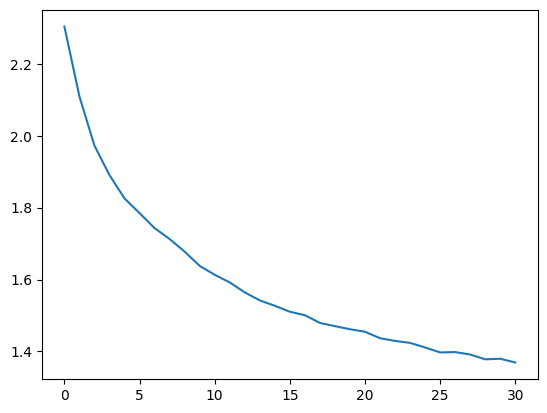

In [ ]:
plt.plot([v for _, v in history.losses_centralized])

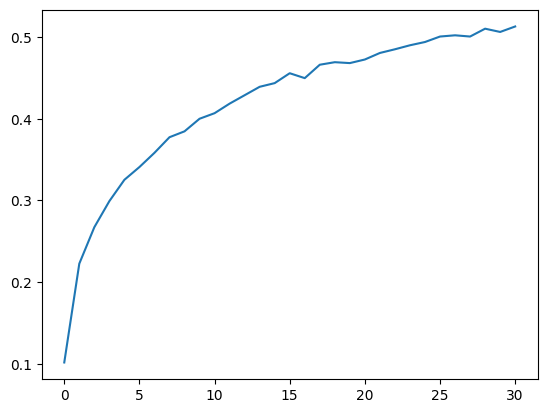

In [ ]:
plt.plot([v for _, v in history.metrics_centralized["accuracy"]])